# Hebrew Multi-Class Text Classification with Scikit-Learn

### Load Data

In [1]:
import pandas as pd

df=pd.read_csv("fashion_data.csv",index_col=[0],header=[0])
df=df.dropna()
df=df.drop_duplicates()
df=df.reset_index(drop=True)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24376 entries, 0 to 24375
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   description  24376 non-null  object
 1   category     24376 non-null  object
 2   label        24376 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 571.4+ KB


In [3]:
df.sample(10)

,description,category,label
18181,מעיל דמוי עור קשירה במותן,coats&jackets_women,1
14002,שמלה מלמלה,dresses_women,2
18810,מגפוני דמוי עור,shoes_women,7
22506,חולצה קשר בחזית,dresses_women,2
13895,שמלת סקייטר פרחונית בצבע טבעי,dresses_women,2
11325,בגד ים מחטב צווארון סקופ,swimwear_women,10
8148,גלבייה דגם בצבע כחול,swimwear_women,10
21062,טי שירט קאט אאוט,shirts_women,6
10522,שמלה דגם טקסטורה,dresses_women,2
1932,סריג תחרה,sweaters_women,9


### Explore Data

#### Number of items per category

In [4]:
df_group = df.groupby("category")
df_group = df_group.agg({"description": "nunique"})
df_group = df_group.reset_index()
df_group.head(13)

,category,description
0,belts&ties_women,219
1,coats&jackets_women,1614
2,dresses_women,4000
3,hats&scarves_women,613
4,lingerie_women,1484
5,nightwear_women,503
6,shirts_women,5620
7,shoes_women,2836
8,skirts_women,878
9,socks_women,378


Text(0.5, 0, 'Class')

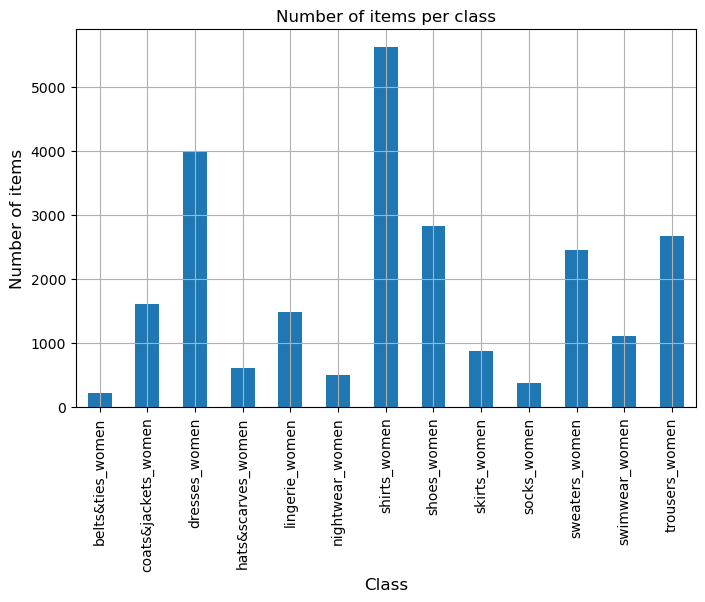

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100

df_group.plot(x='category', y='description', kind='bar', legend=False, grid=True, figsize=(8, 5))
plt.title("Number of items per class")
plt.ylabel('Number of items', fontsize=12)
plt.xlabel('Class', fontsize=12)

#### Top n words

In [6]:
import operator

In [7]:
def get_freq(lemmas_lst):
    freq_dict = {}
    for lemmas in lemmas_lst:
        try:
            lemma_tokens=lemmas.split()
            for t in lemma_tokens:
                freq_dict[t.strip()] = freq_dict.get(t.strip(), 0) + 1
        except:
            continue
    return freq_dict

In [8]:
def get_top_n_words(freq_dict, n):
    sorted_dict = sorted(freq_dict.items(), key=operator.itemgetter(1), reverse=True)
    return [x[0] for x in sorted_dict][:n]

In [9]:
freq_dict = get_freq(df['description'].values)

In [10]:
top_keywords = get_top_n_words(freq_dict, 20)
top_keywords

['דגם',
 'שמלת',
 'חולצת',
 'בצבע',
 'חולצה',
 'טי',
 'בהדפס',
 'צווארון',
 'שמלה',
 'חצאית',
 'מכנסי',
 'סוודר',
 'בשחור',
 'מידי',
 'הדפס',
 'בגזרה',
 'נעלי',
 'עור',
 'גינס',
 'טופ']

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2))
features = tfidf.fit_transform(df.description).toarray()
labels = df.label
features.shape

(24376, 4253)

In [12]:
category_id_df = df[['category', 'label']].drop_duplicates().sort_values('label')
category_to_id = dict(category_id_df.values)

In [13]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for category, label in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == label)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(category))
    print("  - Most correlated unigrams:\n* {}".format('\n* '.join(unigrams[-N:])))
    print("  - Most correlated bigrams:\n* {}".format('\n* '.join(bigrams[-N:])))

# 'belts&ties_women':
  - Most correlated unigrams:
* אבזם
* חגורת
  - Most correlated bigrams:
* חגורת דמוי
* חגורת עור
# 'coats&jackets_women':
  - Most correlated unigrams:
* מעיל
* זקט
  - Most correlated bigrams:
* גקט גינס
* זקט מרופד
# 'dresses_women':
  - Most correlated unigrams:
* שמלה
* שמלת
  - Most correlated bigrams:
* שמלת מיני
* שמלת מידי
# 'hats&scarves_women':
  - Most correlated unigrams:
* כובע
* צעיף
  - Most correlated bigrams:
* סרט לשיער
* כובע גרב
# 'lingerie_women':
  - Most correlated unigrams:
* גוף
* חזיית
  - Most correlated bigrams:
* חזיית ספורט
* בגד גוף
# 'nightwear_women':
  - Most correlated unigrams:
* חלוק
* פיגמה
  - Most correlated bigrams:
* סט פיגמה
* חליפת פנאי
# 'shirts_women':
  - Most correlated unigrams:
* חולצה
* חולצת
  - Most correlated bigrams:
* טי שירט
* חולצת טי
# 'shoes_women':
  - Most correlated unigrams:
* עקב
* נעלי
  - Most correlated bigrams:
* נעלי עקב
* נעלי ספורט
# 'skirts_women':
  - Most correlated unigrams:
* עיפרון
* ח

#### Word Cloud

In [14]:
from wordcloud import WordCloud
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [15]:
def generate_word_cloud(text):
    wordcloud = WordCloud(width = 600, height = 600, 
                    background_color ='white', 
                    max_words=200, 
                    min_font_size = 10,
                    font_path='davidbd.ttf').generate(text)
    return wordcloud

In [16]:
from bidi.algorithm import get_display
cleaned_text=list()

for i,r in df.iterrows():
    text=r['description']
    if isinstance(text, str):
        bidi_text = get_display(text)
        cleaned_text.append(bidi_text)

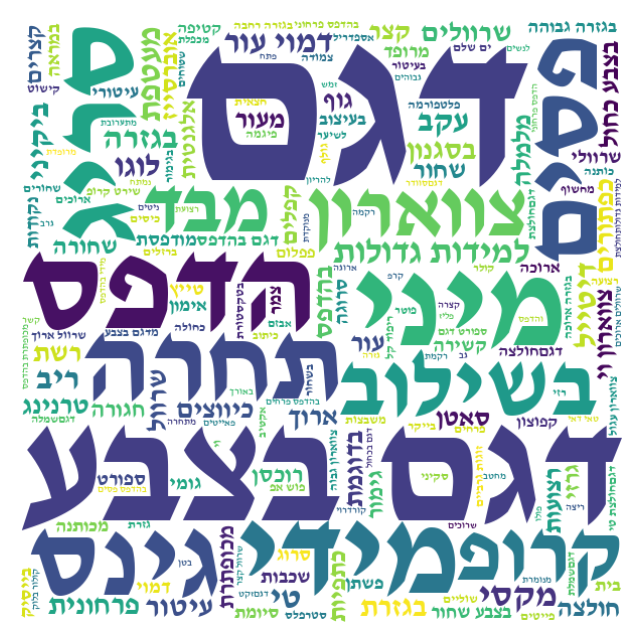

In [17]:
wordcloud = generate_word_cloud(''.join(cleaned_text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Model Data

#### Building Train and Test Datasets

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(np.array(df['description']), np.array(df['category']), test_size=0.33, random_state=42)
X_train.shape, X_test.shape

((16331,), (8045,))

#### Feature Engineering

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

cv=CountVectorizer(max_features=1500)
cv_train_features = cv.fit_transform(X_train)
cv_test_features = cv.transform(X_test)

In [20]:
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB(alpha=1)
mnb.fit(cv_train_features, y_train)

mnb_test_score = mnb.score(cv_test_features, y_test)
mnb_cv_scores = cross_val_score(mnb, cv_train_features, y_train, cv=5)
mnb_cv_mean_score = np.mean(mnb_cv_scores)
print('Cross Validation Accuracy (5-fold):', mnb_cv_scores)
print('Mean of Cross Validation Accuracy:', mnb_cv_mean_score)
print('Test Accuracy:', mnb_test_score)

Cross Validation Accuracy (5-fold): [0.92653811 0.93386405 0.92927128 0.92345377 0.93478261]
Mean of Cross Validation Accuracy: 0.9295819633736462
Test Accuracy: 0.9320074580484773


In [21]:
cv_pred_features = cv.transform(['שמלה פרחונית ארוכה','מכנסי גינס','חולצה מכופתרת'])
mnb.predict(cv_pred_features)

array(['dresses_women', 'trousers_women', 'shirts_women'], dtype='<U19')

In [22]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(penalty='l2',solver='lbfgs', max_iter=100, C=1, random_state=42)
lr.fit(cv_train_features, y_train)

lr_test_score = lr.score(cv_test_features, y_test)
lr_cv_scores = cross_val_score(lr, cv_train_features, y_train, cv=5)
lr_cv_mean_score = np.mean(lr_cv_scores)
print('Cross Validation Accuracy (5-fold):', lr_cv_scores)
print('Mean of Cross Validation Accuracy:', lr_cv_mean_score)
print('Test Accuracy:', lr_test_score)

Cross Validation Accuracy (5-fold): [0.94612795 0.94947949 0.95101041 0.94029394 0.955297  ]
Mean of Cross Validation Accuracy: 0.9484417557901942
Test Accuracy: 0.9475450590428838


In [23]:
cv_pred_features = cv.transform(['שמלה פרחונית ארוכה','מכנסי גינס','חולצה מכופתרת'])
lr.predict(cv_pred_features)

array(['dresses_women', 'trousers_women', 'shirts_women'], dtype=object)

In [26]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=10, random_state=42)
rfc.fit(cv_train_features, y_train)
rfc_cv_scores = cross_val_score(rfc, cv_train_features, y_train, cv=5)
rfc_cv_mean_score = np.mean(rfc_cv_scores)
print('Cross Validation Accuracy (5-fold):', rfc_cv_scores)
print('Mean of Cross Validation Accuracy:', rfc_cv_mean_score)
rfc_test_score = rfc.score(cv_test_features, y_test)
print('Test Accuracy:', rfc_test_score)

Cross Validation Accuracy (5-fold): [0.93480257 0.93325168 0.94213105 0.92804654 0.93937538]
Mean of Cross Validation Accuracy: 0.935521445035446
Test Accuracy: 0.9306401491609696


In [27]:
cv_pred_features = cv.transform(['שמלה פרחונית ארוכה','מכנסי גינס','חולצה מכופתרת'])
rfc.predict(cv_pred_features)

array(['dresses_women', 'trousers_women', 'shirts_women'], dtype=object)

In [31]:
pd.DataFrame([['Naive Bayes', mnb_cv_mean_score, mnb_test_score],
              ['Logistic Regression', lr_cv_mean_score, lr_test_score],
              ['Random Forest', rfc_cv_mean_score, rfc_test_score]],
             columns=['Model', 'CV Score (TF)', 'Test Score (TF)'],
             ).T

,0,1,2
Model,Naive Bayes,Logistic Regression,Random Forest
CV Score (TF),0.929582,0.948442,0.935521
Test Score (TF),0.932007,0.947545,0.93064
